# COO Coding Assigment
### Name: Divyansh Rastogi
### Roll: 2019464
### Question: 3

In [52]:
import numpy as np 
import scipy.optimize
import matplotlib.pyplot as plt

## Part 1: Setting up portfolio investment problem
- We use `scipy.optimize.minimze` for constrained minimization. 
- Method used `SLSQP`

#### [docs for scipy.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)  
#### [docs for SLSQP](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#sequential-least-squares-programming-slsqp-algorithm-method-slsqp)

## Modelling the problem
- Considering $ n = 20 $ assets

- $ x \ \in \ R^{n} $ where $ x $ denotes the fractional investment in assets 

#### Minimize 
$$
x^T.V.x
$$

#### Under Inequality constraint
$$
\langle\ p_m, x \rangle \ \geq \ r_{min}
$$
$$
x \succeq 0
$$

#### Under Equality constraint
$$
1^T.x = 1
$$

$ p_m $ denotes mean fractional return  $( p_m \ \in \ R^{n} )$.

$ V $ denotes covariance of fractional return $( V \ \in \ R^{n \ \times \ n} )$

In [53]:
class PortfolioOptimization:
    def __init__(self, n, B=1, r_min=None, m=None, V=None, idV=True):
        '''
        params:
            n: number of assets
            B: total wealth
            r_min: minimum acceptable mean return
        
        fractional return vector params:
            m: mean vector 
            V: covariance
         '''

        self.n = n
        self.B = B 
        self.r_min = (5*B/100) if r_min is None else r_min 
        # In case min return not specificed, take it to be 5% of total investement

        if m is None:
            self.m = 2 * np.random.rand(n) - 0.25
        else:
            self.m = m
        
        if V is None and idV:
            self.V = np.identity(n) # has to be symmetric
        elif V is None:
            t = 2 * np.random.rand(n, n) +  np.identity(n) - 1
            self.V = np.dot(t, t.T)
        else:
            assert(np.all(V == V.T))
            self.V = V

    # minimize 
    def f(x, *args):
        po = args[0]
        # assert (isinstance(po, PortfolioOptimization))
        return x.dot(po.V @ x)

    # gradient vector of f
    def jac_f(x, *args):
        po = args[0]
        # assert (isinstance(po, PortfolioOptimization))
        return 2 * (po.V @ x)

    # minimum acceptable mean return
    # f_r_min(x) >= 0
    def f_r_min(x, *args):
        po = args[0]
        # assert (isinstance(po, PortfolioOptimization))
        return np.array([x.dot(po.m) - po.r_min])

    def jac_f_r_min(x, *args):
        po = args[0]
        # assert (isinstance(po, PortfolioOptimization))
        return po.m.copy()

    # total investment should sum to B
    def f_tot(x, *args):
        po = args[0]
        # assert (isinstance(po, PortfolioOptimization))
        return np.array(np.sum(x) - po.B)
    
    def jac_f_tot(x, *args):
        return np.ones_like(x)

    def run(self, x0=None):

        bounds = scipy.optimize.Bounds(0, np.inf)

        ineq_cons = {
            'type': 'ineq',
            'fun': PortfolioOptimization.f_r_min,
            'jac': PortfolioOptimization.jac_f_r_min,
            'args': (self,)
        }

        eq_cons = {
            'type': 'eq',
            'fun': PortfolioOptimization.f_tot,
            'jac': PortfolioOptimization.jac_f_tot,
            'args': (self,)
        }

        if x0 is None:
            x0 = np.random.rand(self.n)
            x0 /= sum(x0)

        res = scipy.optimize.minimize(
            PortfolioOptimization.f,
            x0,
            method='SLSQP',
            jac=PortfolioOptimization.jac_f,
            constraints=(eq_cons, ineq_cons),
            bounds=bounds,
            options={'disp': True},
            args=(self,)
        )

        return res

## Part 2
- min return is taken to be 5% of total wealth
- `m` and `V` are chosen as specified in class `PortfolioOptimization`
- `V` is chosen as a positive semi definite matrix to make our optimization convex
- `m` can have some negative values, simulating drop in prices

In [54]:
po = PortfolioOptimization(n=20, idV=False)
print(f"Chosen m: {po.m}")
print(f"Chosen V: {po.V}")

Chosen m: [ 0.63556837  0.24790317  1.68698443  1.54910404  1.44097463  0.94673991
  1.39542278  1.69454739  1.17090149  0.47892029  0.27659233  0.30447301
  1.73698959 -0.0758596   0.58405755  1.62999962  0.79757646  0.56544923
  0.12568341  0.86768017]
Chosen V: [[ 1.09354149e+01  1.00307048e+00 -2.09359614e+00 -3.39141399e-01
   7.60549536e-01 -2.60779422e+00 -3.18821685e+00 -9.41350844e-01
  -1.13892353e+00 -3.65825380e+00  1.81255937e+00 -6.15420882e-01
  -9.93158500e-01  6.27301826e-01  1.41041064e+00 -1.52905382e+00
   1.33228076e+00  5.23055875e+00 -1.93639932e+00 -6.51658945e-01]
 [ 1.00307048e+00  7.15059951e+00  2.39987612e+00 -1.20710397e+00
  -5.54216967e-01  6.23543704e-01 -3.62643471e-01  1.17976487e+00
  -3.15439857e+00  2.10941515e+00  5.40312148e-03  2.85516331e+00
  -5.56253946e-01  3.03513165e+00 -2.52271550e+00  2.41650913e+00
  -2.38412024e-01 -4.61040577e-01 -7.10954863e-01 -1.23529518e+00]
 [-2.09359614e+00  2.39987612e+00  8.87702195e+00 -2.87178554e+00
   2.22

In [55]:
# Evaluating
res = po.run()
print("\nOptimization result")
print(res)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.08112586972063644
            Iterations: 18
            Function evaluations: 32
            Gradient evaluations: 18

Optimization result
     fun: 0.08112586972063644
     jac: array([0.16284914, 0.16388756, 0.16445128, 0.16084882, 0.26484408,
       0.16114564, 0.16155065, 0.16558451, 0.16195686, 0.22825068,
       0.416816  , 0.61209723, 0.37891767, 0.16458799, 0.16246329,
       0.30323454, 0.16331836, 0.16180849, 0.16367943, 0.28012115])
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([7.02522976e-02, 3.22249621e-02, 2.55701873e-02, 6.27903053e-02,
       4.31590876e-17, 1.73893060e-01, 2.47008128e-01, 4.38205119e-02,
       4.83637947e-04, 0.00000000e+00, 1.42106779e-16, 4.62227701e-17,
       4.11476258e-17, 7.37254408e-03, 5.80950218e-02, 0.00000000e+00,
       2.62052434e-02, 1.40214335e-01, 1.1206976

In [56]:
# Cross checking inequality constraints >= 0
PortfolioOptimization.f_r_min(res.x, po)

array([0.87482017])

In [57]:
# Cross checking equality constraints = 0
PortfolioOptimization.f_tot(res.x, po)

array(2.22044605e-16)

## Part 3
- `min_target_returns` is upper-bounded on 1 for `m` (mean fractional return) to be upper-bounded on 1.25
- Thereby, we simulate maximum & minimum mean increase in asset to be 125% and -25% respectively, while varying min returns to be from 0% to 100%
- `V` is chosen as a positive semi definite matrix with maximum covariance of 1.

In [58]:
# Choosing returns from 0% to 100%
min_target_returns = np.linspace(0, 1, num=200)

n = 20
# Choosing fractional return mean and covariance
base_m = np.random.rand(n)
m = 1.5 * base_m - 0.25
t = np.random.rand(n, n)
V = np.dot(t, t.T)

# Calculating risks
risks = []
returns = []
for y in min_target_returns:
    po_obj = PortfolioOptimization(n=n, r_min=y, m=m, V=V)
    opt = po_obj.run().x
    risks.append(PortfolioOptimization.f(opt, po_obj)) 
    returns.append(PortfolioOptimization.f_r_min(opt, po_obj)[0] + y)
    print("Ineq constraint: ", PortfolioOptimization.f_r_min(opt, po_obj)[0])
    print("Eq constraint: ", PortfolioOptimization.f_tot(opt, po_obj))
    assert(PortfolioOptimization.f_r_min(opt, po_obj)[0] >= -1e-8)
    assert(PortfolioOptimization.f_tot(opt, po_obj) < 1e-8)

 (Exit mode 0)
            Current function value: 3.466264036084498
            Iterations: 4
            Function evaluations: 4
            Gradient evaluations: 4
Ineq constraint:  2.9976021664879227e-15
Eq constraint:  6.8833827526759706e-15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.4703467529910377
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5
Ineq constraint:  5.329070518200751e-15
Eq constraint:  9.325873406851315e-15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.4745863906128194
            Iterations: 4
            Function evaluations: 4
            Gradient evaluations: 4
Ineq constraint:  2.220446049250313e-16
Eq constraint:  3.3306690738754696e-15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.4789828102973868
            Iterations: 5
            Function evaluations: 5
        

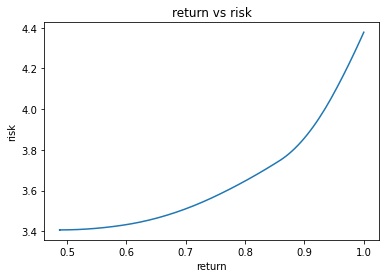

In [59]:
# Plotting risks vs returns
plt.plot(returns, risks)
plt.ylabel('risk')
plt.xlabel('return')
plt.title('return vs risk')
plt.show()

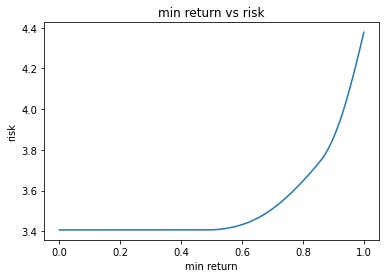

In [60]:
# Plotting risks vs min return
plt.plot(min_target_returns, risks)
plt.ylabel('risk')
plt.xlabel('min return')
plt.title('min return vs risk')
plt.show()

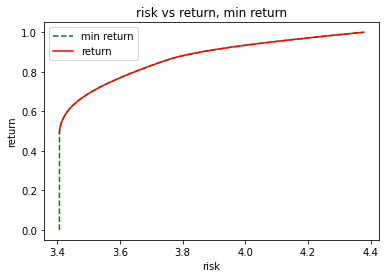

In [61]:
# Plotting risks vs returns, min return
plt.plot(risks, min_target_returns, '--g', label='min return')
plt.plot(risks, returns, 'r', label='return')
plt.xlabel('risk')
plt.ylabel('return')
plt.title('risk vs return, min return')
plt.legend()
plt.show()

## Bonus
Distributional assumptions used to generate `m` **affects** final solution obtained.
As `m` denotes the mean fractional return, our current mean distribution ensures that *every* return from `min_target_returns` is comparitively probabilisticly achievable.  
- Current returns fall in range of 0% --> 100%
- Current fractional mean returns falls in range of -25% --> 125%

Now we take `m` to be a vector which highers the probability of achieving our minimum returns even more
- New fractional mean returns falls in range of 0% --> 175%

**We observe** that for the same min-return, we are getting a lower risk in our new setting as compared to the previous setting i.e. *higher fractional return mean implies a lower risk for a given min-return*

#### Note for bonus analysis: For comparison with previous results, `V`, `n`, `min_target_returns` stays same as above.

In [62]:
# Choosing new fractional return mean
# Note the maximum and minimum values of m
m = 1.75 * base_m

# Calculating risks
risks = []
returns = []
for y in min_target_returns:
    po_obj = PortfolioOptimization(n=n, r_min=y, m=m, V=V)
    opt = po_obj.run().x
    risks.append(PortfolioOptimization.f(opt, po_obj)) 
    returns.append(PortfolioOptimization.f_r_min(opt, po_obj)[0] + y)
    print("Ineq constraint: ", PortfolioOptimization.f_r_min(opt, po_obj)[0])
    print("Eq constraint: ", PortfolioOptimization.f_tot(opt, po_obj))
    assert(PortfolioOptimization.f_r_min(opt, po_obj)[0] >= -1e-8)
    assert(PortfolioOptimization.f_tot(opt, po_obj) < 1e-8)

80085382e-14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.406705605904737
            Iterations: 8
            Function evaluations: 10
            Gradient evaluations: 8
Ineq constraint:  0.20727674443808408
Eq constraint:  7.993605777301127e-15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.4067056119960504
            Iterations: 9
            Function evaluations: 10
            Gradient evaluations: 9
Ineq constraint:  0.20226983356515482
Eq constraint:  5.329070518200751e-15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.40670560023445
            Iterations: 8
            Function evaluations: 10
            Gradient evaluations: 8
Ineq constraint:  0.19723116760969905
Eq constraint:  1.1324274851176597e-14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.4067056144086507
            Iterations: 

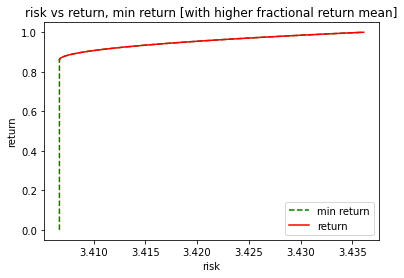

In [63]:
# Plotting risks vs returns, min return
plt.plot(risks, min_target_returns, '--g', label='min return')
plt.plot(risks, returns, 'r', label='return')
plt.xlabel('risk')
plt.ylabel('return')
plt.title('risk vs return, min return [with higher fractional return mean]')
plt.legend()
plt.show()